In [7]:
import numpy as np
import pandas as pd
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Transformers for sentiment analysis
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    pipeline
)
import torch

# Text preprocessing
import re
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


class SentimentAnalyzer:
    """
    Sentiment Analysis Model for customer feedback
    Supports multiple pre-trained models and custom analysis
    """
    
    def __init__(self, model_name: str = "distilbert-base-uncased-finetuned-sst-2-english"):
        """
        Initialize sentiment analyzer
        
        Args:
            model_name: Hugging Face model name
                - "distilbert-base-uncased-finetuned-sst-2-english" (default)
                - "cardiffnlp/twitter-roberta-base-sentiment"
                - "nlptown/bert-base-multilingual-uncased-sentiment"
        """
        self.model_name = model_name
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        
        print(f"Loading model: {model_name}")
        print(f"Using device: {self.device}")
        
        # Load model and tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name)
        self.model.to(self.device)
        
        # Create pipeline
        self.sentiment_pipeline = pipeline(
            "sentiment-analysis",
            model=self.model,
            tokenizer=self.tokenizer,
            device=0 if self.device == "cuda" else -1
        )
        
        # Concern keywords dictionary
        self.concern_keywords = {
            'pricing': ['expensive', 'costly', 'price', 'overpriced', 'cheap', 'affordable'],
            'quality': ['quality', 'poor', 'excellent', 'bad', 'good', 'defective', 'broken'],
            'service': ['service', 'support', 'help', 'staff', 'representative', 'agent'],
            'delivery': ['delivery', 'shipping', 'late', 'delayed', 'fast', 'quick', 'slow'],
            'product': ['product', 'item', 'feature', 'functionality', 'works', "doesn't work"],
            'wait_time': ['wait', 'waiting', 'hold', 'queue', 'response time', 'slow response'],
            'communication': ['communication', 'informed', 'update', 'notification', 'response']
        }
    
    def preprocess_text(self, text: str) -> str:
        """Clean and preprocess text"""
        if not isinstance(text, str):
            return ""
        
        # Convert to lowercase
        text = text.lower()
        
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        
        # Remove email addresses
        text = re.sub(r'\S+@\S+', '', text)
        
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    
    def analyze_single(self, text: str) -> Dict:
        """
        Analyze sentiment of a single text
        
        Args:
            text: Input text to analyze
            
        Returns:
            Dictionary with sentiment analysis results
        """
        if not text or not isinstance(text, str):
            return {
                'text': text,
                'sentiment': 'neutral',
                'confidence': 0.0,
                'sentiment_score': 0.0,
                'concerns': []
            }
        
        # Preprocess
        clean_text = self.preprocess_text(text)
        
        # Get sentiment prediction
        result = self.sentiment_pipeline(clean_text[:512])[0]  # Limit to 512 tokens
        
        # Map label to standard sentiment
        sentiment = self._map_sentiment(result['label'])
        confidence = result['score']
        
        # Calculate sentiment score (-1 to 1)
        sentiment_score = self._calculate_sentiment_score(sentiment, confidence)
        
        # Extract concerns
        concerns = self._extract_concerns(clean_text)
        
        return {
            'text': text,
            'sentiment': sentiment,
            'confidence': confidence,
            'sentiment_score': sentiment_score,
            'concerns': concerns,
            'raw_prediction': result
        }
    
    def analyze_batch(self, texts: List[str]) -> pd.DataFrame:
        """
        Analyze sentiment for multiple texts
        
        Args:
            texts: List of texts to analyze
            
        Returns:
            DataFrame with analysis results
        """
        results = []
        
        for i, text in enumerate(texts):
            if (i + 1) % 10 == 0:
                print(f"Processed {i + 1}/{len(texts)} feedbacks...")
            
            result = self.analyze_single(text)
            results.append(result)
        
        df = pd.DataFrame(results)
        return df
    
    def _map_sentiment(self, label: str) -> str:
        """Map model-specific labels to standard sentiment"""
        label = label.lower()
        
        # Handle different model outputs
        if 'pos' in label or label == 'positive' or label == '5 stars' or label == '4 stars':
            return 'positive'
        elif 'neg' in label or label == 'negative' or label == '1 star' or label == '2 stars':
            return 'negative'
        else:
            return 'neutral'
    
    def _calculate_sentiment_score(self, sentiment: str, confidence: float) -> float:
        """Calculate normalized sentiment score between -1 and 1"""
        if sentiment == 'positive':
            return confidence
        elif sentiment == 'negative':
            return -confidence
        else:
            return 0.0
    
    def _extract_concerns(self, text: str) -> List[str]:
        """Extract specific concerns from text"""
        concerns = []
        text_lower = text.lower()
        
        for concern, keywords in self.concern_keywords.items():
            if any(keyword in text_lower for keyword in keywords):
                concerns.append(concern)
        
        return concerns
    
    def get_summary_stats(self, df: pd.DataFrame) -> Dict:
        """
        Get summary statistics from analysis results
        
        Args:
            df: DataFrame with analysis results
            
        Returns:
            Dictionary with summary statistics
        """
        stats = {
            'total_feedbacks': len(df),
            'sentiment_distribution': df['sentiment'].value_counts().to_dict(),
            'sentiment_percentages': (df['sentiment'].value_counts(normalize=True) * 100).round(2).to_dict(),
            'average_sentiment_score': df['sentiment_score'].mean(),
            'average_confidence': df['confidence'].mean(),
            'most_common_concerns': self._get_top_concerns(df),
            'positive_feedback_count': (df['sentiment'] == 'positive').sum(),
            'negative_feedback_count': (df['sentiment'] == 'negative').sum(),
            'neutral_feedback_count': (df['sentiment'] == 'neutral').sum()
        }
        
        return stats
    
    def _get_top_concerns(self, df: pd.DataFrame, top_n: int = 5) -> List[Tuple[str, int]]:
        """Get most common concerns"""
        all_concerns = []
        for concerns_list in df['concerns']:
            all_concerns.extend(concerns_list)
        
        concern_counts = Counter(all_concerns)
        return concern_counts.most_common(top_n)
    
    def visualize_results(self, df: pd.DataFrame, save_path: Optional[str] = None):
        """
        Create visualization of sentiment analysis results
        
        Args:
            df: DataFrame with analysis results
            save_path: Optional path to save the plot
        """
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. Sentiment Distribution
        sentiment_counts = df['sentiment'].value_counts()
        colors = {'positive': '#2ecc71', 'neutral': '#95a5a6', 'negative': '#e74c3c'}
        ax1_colors = [colors.get(s, '#3498db') for s in sentiment_counts.index]
        
        axes[0, 0].bar(sentiment_counts.index, sentiment_counts.values, color=ax1_colors)
        axes[0, 0].set_title('Sentiment Distribution', fontsize=14, fontweight='bold')
        axes[0, 0].set_xlabel('Sentiment')
        axes[0, 0].set_ylabel('Count')
        axes[0, 0].grid(axis='y', alpha=0.3)
        
        # 2. Sentiment Score Distribution
        axes[0, 1].hist(df['sentiment_score'], bins=30, color='#3498db', edgecolor='black', alpha=0.7)
        axes[0, 1].axvline(df['sentiment_score'].mean(), color='red', linestyle='--', 
                          label=f'Mean: {df["sentiment_score"].mean():.2f}')
        axes[0, 1].set_title('Sentiment Score Distribution', fontsize=14, fontweight='bold')
        axes[0, 1].set_xlabel('Sentiment Score')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].legend()
        axes[0, 1].grid(alpha=0.3)
        
        # 3. Confidence Distribution by Sentiment
        df_plot = df[['sentiment', 'confidence']].copy()
        sentiment_order = ['negative', 'neutral', 'positive']
        df_plot['sentiment'] = pd.Categorical(df_plot['sentiment'], categories=sentiment_order, ordered=True)
        
        df_plot.boxplot(column='confidence', by='sentiment', ax=axes[1, 0])
        axes[1, 0].set_title('Confidence Score by Sentiment', fontsize=14, fontweight='bold')
        axes[1, 0].set_xlabel('Sentiment')
        axes[1, 0].set_ylabel('Confidence Score')
        plt.sca(axes[1, 0])
        plt.xticks(rotation=0)
        
        # 4. Top Concerns
        top_concerns = self._get_top_concerns(df, top_n=8)
        if top_concerns:
            concerns, counts = zip(*top_concerns)
            axes[1, 1].barh(concerns, counts, color='#e67e22')
            axes[1, 1].set_title('Most Common Concerns', fontsize=14, fontweight='bold')
            axes[1, 1].set_xlabel('Frequency')
            axes[1, 1].set_ylabel('Concern Category')
            axes[1, 1].grid(axis='x', alpha=0.3)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Visualization saved to {save_path}")
        
        plt.show()

In [8]:
def demo_usage():
    """Demonstrate the sentiment analyzer with sample data"""
    
    # Sample customer feedback
    sample_feedback = [
        "Excellent service! The staff was very helpful and friendly. Highly recommend!",
        "The product quality is terrible. It broke after just one use. Very disappointed.",
        "Average experience. Nothing special but nothing terrible either.",
        "Delivery was extremely late and customer service was unresponsive. Very frustrated!",
        "Great product at an affordable price. Fast shipping too!",
        "The wait time was too long, but the representative was polite and solved my issue.",
        "Poor quality for the price. Expected much better. Won't buy again.",
        "Amazing! Everything was perfect from start to finish. Will definitely return!",
        "Product doesn't work as advertised. Trying to get a refund but no response.",
        "Good value for money. Minor issues but overall satisfied with the purchase."
    ]
    
    # Initialize analyzer
    print("=" * 70)
    print("CUSTOMER SENTIMENT ANALYSIS DEMO")
    print("=" * 70)
    
    analyzer = SentimentAnalyzer()
    
    # Analyze feedback
    print("\nAnalyzing customer feedback...\n")
    results_df = analyzer.analyze_batch(sample_feedback)
    
    # Display individual results
    print("\n" + "=" * 70)
    print("INDIVIDUAL ANALYSIS RESULTS")
    print("=" * 70)
    
    for idx, row in results_df.iterrows():
        print(f"\nFeedback #{idx + 1}:")
        print(f"Text: {row['text'][:80]}...")
        print(f"Sentiment: {row['sentiment'].upper()}")
        print(f"Confidence: {row['confidence']:.2%}")
        print(f"Score: {row['sentiment_score']:.3f}")
        print(f"Concerns: {', '.join(row['concerns']) if row['concerns'] else 'None detected'}")
    
    # Get summary statistics
    print("\n" + "=" * 70)
    print("SUMMARY STATISTICS")
    print("=" * 70)
    
    stats = analyzer.get_summary_stats(results_df)
    
    print(f"\nTotal Feedbacks: {stats['total_feedbacks']}")
    print(f"\nSentiment Distribution:")
    for sentiment, count in stats['sentiment_distribution'].items():
        percentage = stats['sentiment_percentages'][sentiment]
        print(f"  {sentiment.capitalize()}: {count} ({percentage}%)")
    
    print(f"\nAverage Sentiment Score: {stats['average_sentiment_score']:.3f}")
    print(f"Average Confidence: {stats['average_confidence']:.2%}")
    
    print(f"\nTop Concerns:")
    for concern, count in stats['most_common_concerns']:
        print(f"  {concern.capitalize()}: {count} occurrences")
    
    # Create visualization
    print("\nGenerating visualization...")
    analyzer.visualize_results(results_df)
    
    return analyzer, results_df

CUSTOMER SENTIMENT ANALYSIS DEMO
Loading model: distilbert-base-uncased-finetuned-sst-2-english
Using device: cpu

Analyzing customer feedback...

Processed 10/10 feedbacks...

INDIVIDUAL ANALYSIS RESULTS

Feedback #1:
Text: Excellent service! The staff was very helpful and friendly. Highly recommend!...
Sentiment: POSITIVE
Confidence: 99.99%
Score: 1.000
Concerns: quality, service

Feedback #2:
Text: The product quality is terrible. It broke after just one use. Very disappointed....
Sentiment: NEGATIVE
Confidence: 99.98%
Score: -1.000
Concerns: quality, product

Feedback #3:
Text: Average experience. Nothing special but nothing terrible either....
Sentiment: NEGATIVE
Confidence: 99.26%
Score: -0.993
Concerns: None detected

Feedback #4:
Text: Delivery was extremely late and customer service was unresponsive. Very frustrat...
Sentiment: NEGATIVE
Confidence: 99.98%
Score: -1.000
Concerns: service, delivery

Feedback #5:
Text: Great product at an affordable price. Fast shipping too!...
S

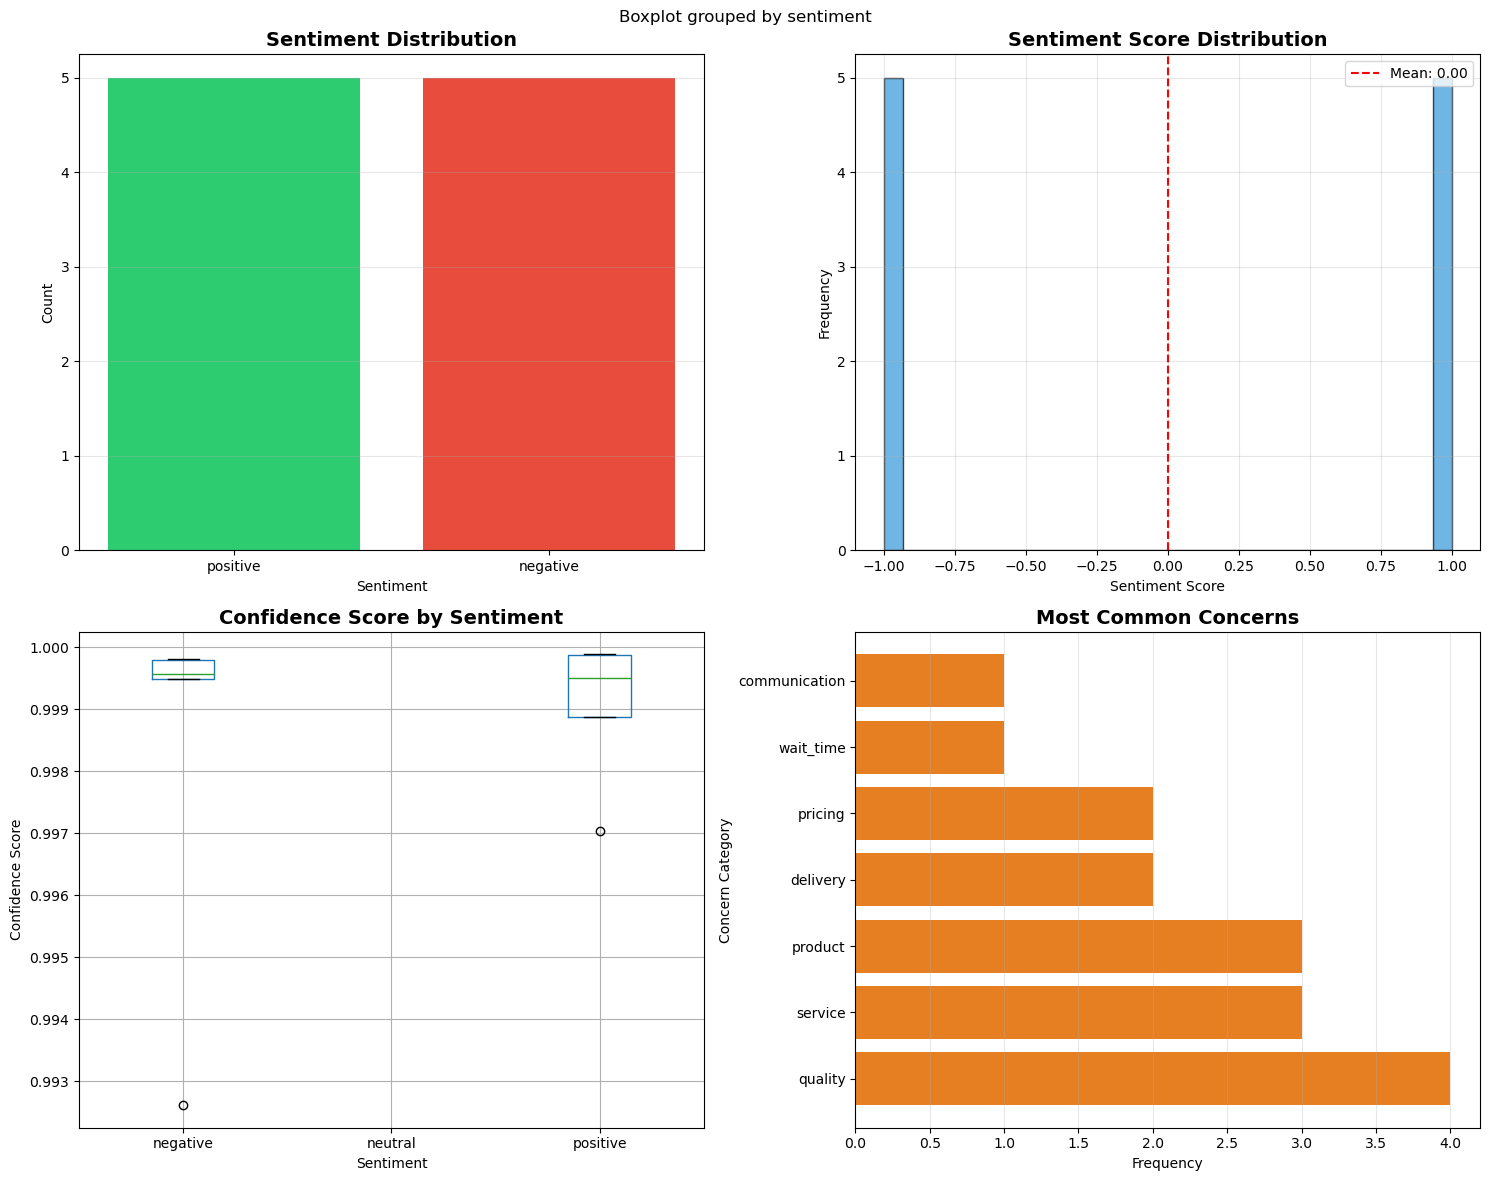

(<__main__.SentimentAnalyzer at 0x1f795f6a3e0>,
                                                 text sentiment  confidence  \
 0  Excellent service! The staff was very helpful ...  positive    0.999875   
 1  The product quality is terrible. It broke afte...  negative    0.999815   
 2  Average experience. Nothing special but nothin...  negative    0.992617   
 3  Delivery was extremely late and customer servi...  negative    0.999800   
 4  Great product at an affordable price. Fast shi...  positive    0.998866   
 5  The wait time was too long, but the representa...  positive    0.997033   
 6  Poor quality for the price. Expected much bett...  negative    0.999564   
 7  Amazing! Everything was perfect from start to ...  positive    0.999883   
 8  Product doesn't work as advertised. Trying to ...  negative    0.999480   
 9  Good value for money. Minor issues but overall...  positive    0.999497   
 
    sentiment_score                      concerns  \
 0         0.999875         

In [9]:
demo_usage()

In [10]:
def save_model_weights(analyzer: SentimentAnalyzer, save_path: str = "./sentiment_model_weights"):
    """
    Save the model weights and tokenizer
    
    Args:
        analyzer: Trained SentimentAnalyzer instance
        save_path: Directory path to save model weights
    """
    import os
    import json
    from datetime import datetime
    
    # Create directory if it doesn't exist
    os.makedirs(save_path, exist_ok=True)
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    print(f"\nSaving model weights to: {save_path}")
    print("=" * 70)
    
    # 1. Save model weights
    model_path = os.path.join(save_path, "pytorch_model.bin")
    torch.save(analyzer.model.state_dict(), model_path)
    print(f"✓ Model weights saved: {model_path}")
    
    # 2. Save tokenizer
    tokenizer_path = os.path.join(save_path, "tokenizer")
    analyzer.tokenizer.save_pretrained(tokenizer_path)
    print(f"✓ Tokenizer saved: {tokenizer_path}")
    
    # 3. Save model configuration
    config_path = os.path.join(save_path, "config.json")
    config = {
        'model_name': analyzer.model_name,
        'device': analyzer.device,
        'concern_keywords': analyzer.concern_keywords,
        'timestamp': timestamp,
        'model_config': analyzer.model.config.to_dict()
    }
    
    with open(config_path, 'w') as f:
        json.dump(config, f, indent=4)
    print(f"✓ Configuration saved: {config_path}")
    
    # 4. Save full model (alternative method)
    full_model_path = os.path.join(save_path, "full_model")
    analyzer.model.save_pretrained(full_model_path)
    print(f"✓ Full model saved: {full_model_path}")
    
    print("\n" + "=" * 70)
    print("MODEL WEIGHTS SAVED SUCCESSFULLY!")
    print("=" * 70)
    print(f"\nTotal size: ~{sum(os.path.getsize(os.path.join(dirpath, filename)) for dirpath, _, filenames in os.walk(save_path) for filename in filenames) / (1024*1024):.2f} MB")
    
    return {
        'model_weights': model_path,
        'tokenizer': tokenizer_path,
        'config': config_path,
        'full_model': full_model_path
    }

CUSTOMER SENTIMENT ANALYSIS DEMO
Loading model: distilbert-base-uncased-finetuned-sst-2-english
Using device: cpu

Analyzing customer feedback...

Processed 10/10 feedbacks...

INDIVIDUAL ANALYSIS RESULTS

Feedback #1:
Text: Excellent service! The staff was very helpful and friendly. Highly recommend!...
Sentiment: POSITIVE
Confidence: 99.99%
Score: 1.000
Concerns: quality, service

Feedback #2:
Text: The product quality is terrible. It broke after just one use. Very disappointed....
Sentiment: NEGATIVE
Confidence: 99.98%
Score: -1.000
Concerns: quality, product

Feedback #3:
Text: Average experience. Nothing special but nothing terrible either....
Sentiment: NEGATIVE
Confidence: 99.26%
Score: -0.993
Concerns: None detected

Feedback #4:
Text: Delivery was extremely late and customer service was unresponsive. Very frustrat...
Sentiment: NEGATIVE
Confidence: 99.98%
Score: -1.000
Concerns: service, delivery

Feedback #5:
Text: Great product at an affordable price. Fast shipping too!...
S

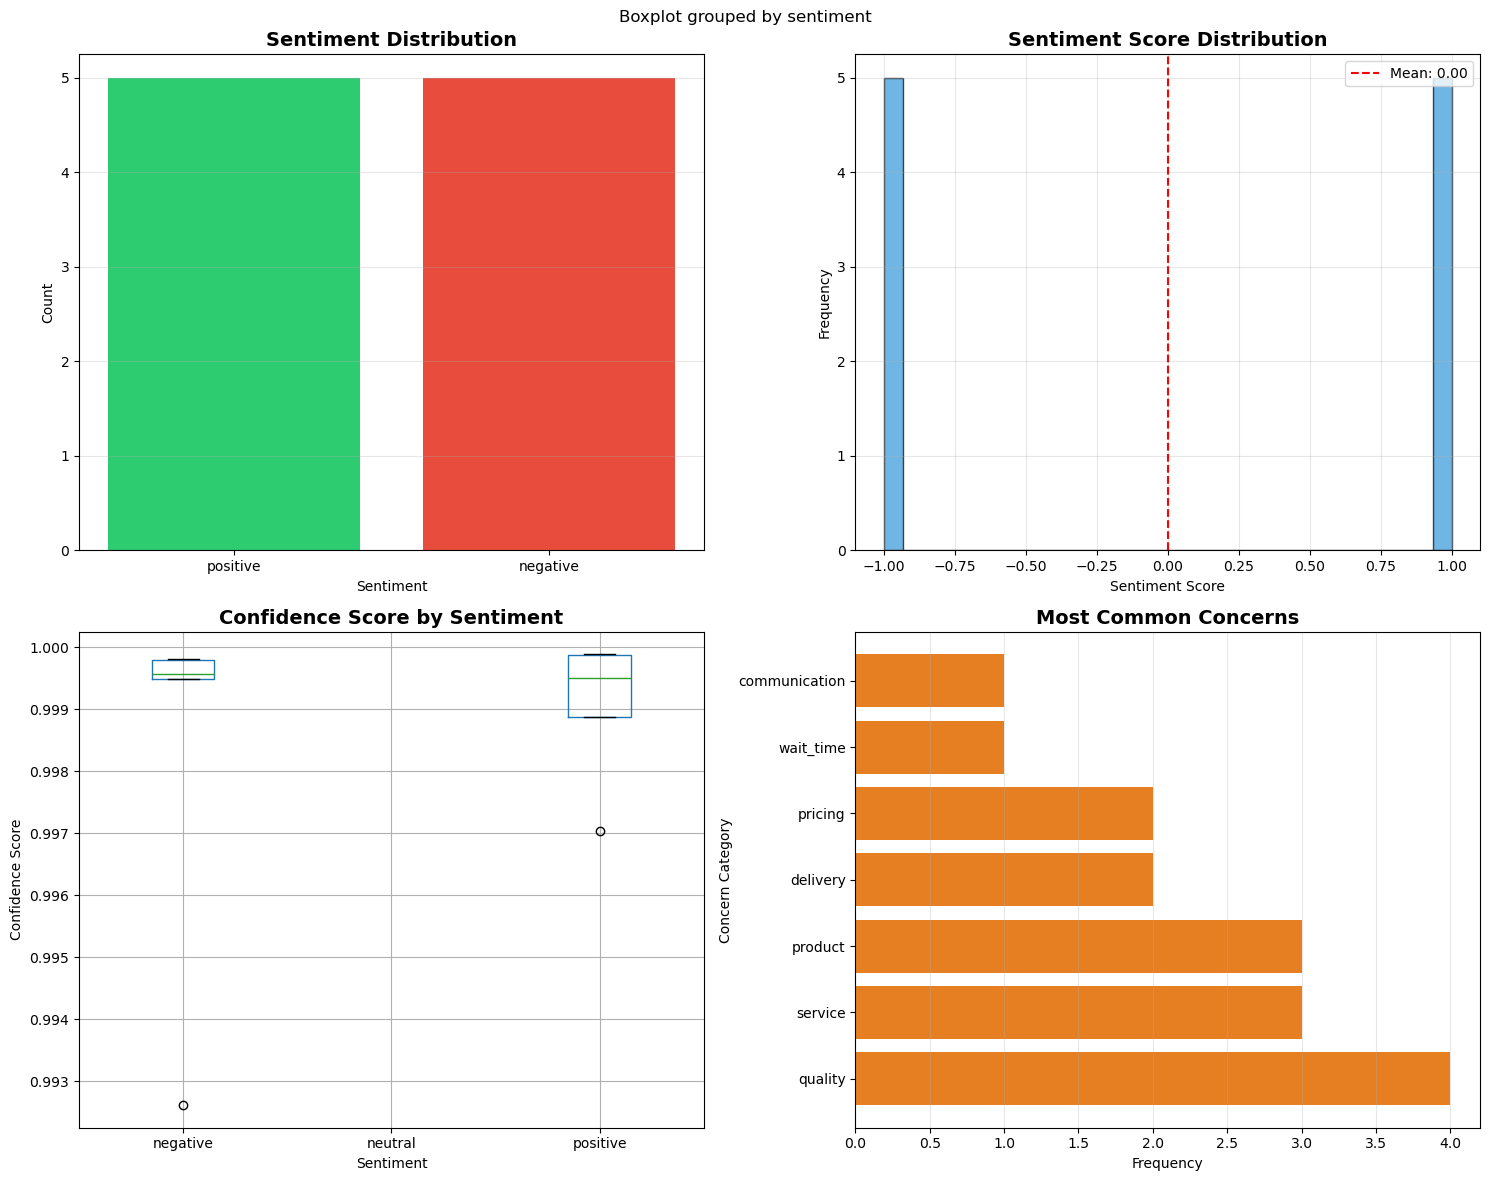


ANALYZING NEW FEEDBACK

Feedback: The product is okay but the customer service was horrible and took forever to respond.
Sentiment: NEGATIVE
Confidence: 99.88%
Sentiment Score: -0.999
Identified Concerns: service, product

SAVING MODEL WEIGHTS

Saving model weights to: ./sentiment_model_weights
✓ Model weights saved: ./sentiment_model_weights\pytorch_model.bin
✓ Tokenizer saved: ./sentiment_model_weights\tokenizer
✓ Configuration saved: ./sentiment_model_weights\config.json
✓ Full model saved: ./sentiment_model_weights\full_model

MODEL WEIGHTS SAVED SUCCESSFULLY!

Total size: ~511.80 MB

Saved files:
  model_weights: ./sentiment_model_weights\pytorch_model.bin
  tokenizer: ./sentiment_model_weights\tokenizer
  config: ./sentiment_model_weights\config.json
  full_model: ./sentiment_model_weights\full_model

LOADING MODEL FROM WEIGHTS


In [11]:
analyzer, results = demo_usage()
    
    # Example: Analyze a new feedback
print("\n" + "=" * 70)
print("ANALYZING NEW FEEDBACK")
print("=" * 70)
    
new_feedback = "The product is okay but the customer service was horrible and took forever to respond."
result = analyzer.analyze_single(new_feedback)
    
print(f"\nFeedback: {result['text']}")
print(f"Sentiment: {result['sentiment'].upper()}")
print(f"Confidence: {result['confidence']:.2%}")
print(f"Sentiment Score: {result['sentiment_score']:.3f}")
print(f"Identified Concerns: {', '.join(result['concerns'])}")
    
    # Save model weights
print("\n" + "=" * 70)
print("SAVING MODEL WEIGHTS")
print("=" * 70)
    
saved_paths = save_model_weights(analyzer, save_path="./sentiment_model_weights")
    
print("\nSaved files:")
for file_type, path in saved_paths.items():
    print(f"  {file_type}: {path}")
    
    # Example: Load model from weights
print("\n" + "=" * 70)
print("LOADING MODEL FROM WEIGHTS")
print("=" * 70)

In [12]:
def load_model_from_weights(weights_path: str) -> SentimentAnalyzer:
    """
    Load model from saved weights
    
    Args:
        weights_path: Path to the directory containing saved weights
        
    Returns:
        SentimentAnalyzer instance with loaded weights
    """
    import json
    import os
    
    print(f"\nLoading model from: {weights_path}")
    print("=" * 70)
    
    # Load configuration
    config_path = os.path.join(weights_path, "config.json")
    with open(config_path, 'r') as f:
        config = json.load(f)
    
    # Initialize analyzer with base model
    print(f"Initializing model: {config['model_name']}")
    analyzer = SentimentAnalyzer(model_name=config['model_name'])
    
    # Load saved weights
    model_weights_path = os.path.join(weights_path, "pytorch_model.bin")
    if os.path.exists(model_weights_path):
        analyzer.model.load_state_dict(torch.load(model_weights_path, map_location=analyzer.device))
        print(f"✓ Loaded model weights from: {model_weights_path}")
    
    # Restore concern keywords
    analyzer.concern_keywords = config['concern_keywords']
    
    print("✓ Model loaded successfully!")
    print("=" * 70)
    
    return analyzer